In [ ]:
# PER : 이익 대비 주가가 몇 배인지 나타내는 수치. 작을수록 저평가
# ROA : 총자산 대비 순이익의 비율. 높을수록 경영이 효율적으로 이루어짐
# ROE : 총자본 대비 순이익의 비율. ROA와 유사하게 해석
# => PER은 낮고 ROA, ROE는 높아야 함

In [1]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
sns.set()
%matplotlib inline
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd

data = pd.read_csv("data/재무제표_분석용데이터.csv", encoding = "euc-kr", usecols = ['기업', '연도', '현재_주가', '미래_주가', 'ROA', 'ROE', 'PER'])
data.dropna(inplace = True)

In [3]:
# 산업군 컬럼 추가

stock_info_data = pd.read_csv("data/종목정보.txt", sep="\t", encoding="euc-kr", usecols=["Name", "Sector"]
)

data = pd.merge(data, stock_info_data, left_on="기업", right_on="Name", how="left")
data.drop(["Name"], axis=1, inplace=True)

In [4]:
# 수익률 추가

data['수익률'] = (data['미래_주가'] - data['현재_주가']) / data['현재_주가'] * 100

## 수익률과 투자 지표 간 상관관계 확인

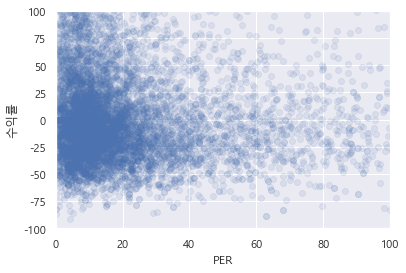

-0.10343527835977333


In [5]:
# per

plt.scatter(data["PER"], data["수익률"], alpha = 0.1)
plt.xlabel("PER")
plt.ylabel("수익률")
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.show()

print(data.corr("spearman").loc["PER", "수익률"])

# -0.1로 아주 약한 상관관계가 있음. PER이 낮아지면 수익률이 높아지는 아주 약한 관계가 있음

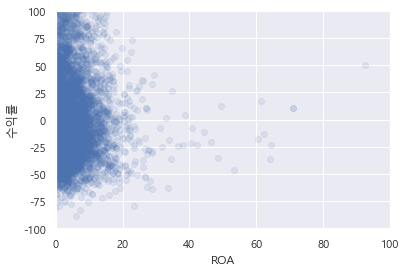

0.02001310222049035


In [6]:
# ROA

plt.scatter(data["ROA"], data["수익률"], alpha = 0.1)
plt.xlabel("ROA")
plt.ylabel("수익률")
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.show()

print(data.corr("spearman").loc["ROA", "수익률"])

# ROA 수치가 대부분 0~20에 군집되어있는것 말고는 별다른 상관관계가 없음

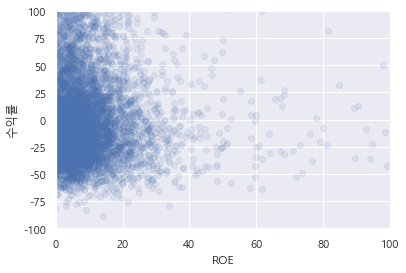

0.013409256658607148


In [8]:
# ROE

plt.scatter(data["ROE"], data["수익률"], alpha = 0.1)
plt.xlabel("ROE")
plt.ylabel("수익률")
plt.xlim(0, 100)
plt.ylim(-100, 100)
plt.show()

print(data.corr("spearman").loc["ROE", "수익률"])

# 위와 같음

In [9]:
# 산업군을 고려한 수익률과 투자 지표 간 상관관계 확인

print(data.drop_duplicates(['기업', 'Sector'])['Sector'].value_counts())

# 산업군 간 종목 갯수 편차가 크므로 출현 빈도로 상위 10개 종목만 시각화

특수 목적용 기계 제조업      100
전자부품 제조업            98
소프트웨어 개발 및 공급업      91
의약품 제조업             79
자동차 신품 부품 제조업       70
                  ... 
인쇄 및 인쇄관련 산업         1
석탄 광업                1
경비, 경호 및 탐정업         1
사업시설 유지·관리 서비스업      1
비알코올음료 및 얼음 제조업      1
Name: Sector, Length: 146, dtype: int64


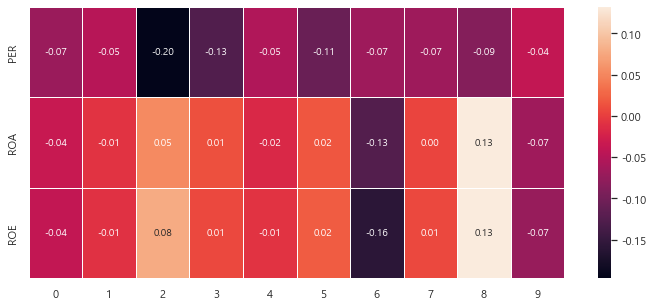

In [10]:
result = []

top10_S = data.drop_duplicates(['기업', 'Sector'])['Sector'].value_counts().index[:10]

for col in ["PER", "ROA", "ROE"]:
    record = []
    for sector in top10_S:
        temp = data.loc[data['Sector'] == sector, [col, '수익률']].dropna()
        corr = temp.corr("spearman").iloc[0, 1]
        record.append(corr)
    result.append(record)

plt.figure(figsize = (12, 5))
sns.heatmap(result, annot=True, fmt=".2f", linewidths=0.5)
plt.yticks([0.5, 1.5, 2.5], ["PER", "ROA", "ROE"])
plt.show()

# 모든 수치의 절대값이 0.3 이하로 눈에 띄는 상관관계는 없음

## 동일 가중 교체 매매에 따른 수익률 비교

<AxesSubplot:>

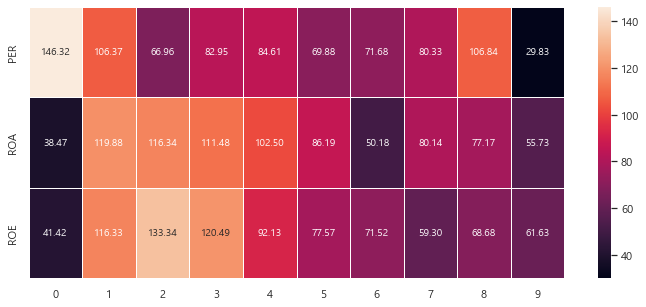

In [12]:
# 전체 산업군

import numpy as np

result = []

for col in ["PER", "ROA", "ROE"]:
    inve_list = np.array([10**8] * 10) # 투자금 초기화
    for year in range(2014, 2020):
        y_data = data.loc[data['연도'] == year]
        group_list = pd.qcut(y_data[col], 10, labels = range(10)).astype(int)
        for group in range(10):
            ror_list = y_data.loc[group_list == group, '수익률']
            inve_per_stock = inve_list[group] / len(ror_list)

            profit = (inve_per_stock * ror_list / 100).sum()
            inve_list[group] += profit

    profit_ratio_list = (inve_list - 10 ** 8) / 10 ** 8 * 100
    result.append(profit_ratio_list)

result = pd.DataFrame(result, columns = range(10), index = ["PER", "ROA", "ROE"])

plt.figure(figsize = (12, 5))
sns.heatmap(result, annot = True, linewidth = 1, fmt = ".2f")

# PER이 가장 작은 그룹 0, 1에 투자하는것이 대부분의 경우보다 높은 수익률을 보임. 그러나 그룹 8와 같이 예외도 있음
# ROA와 ROE는 예상과는 반대로 그룹 1~4처럼 수치가 높지 않은 기업에서 높은 수익률을 보임

<AxesSubplot:>

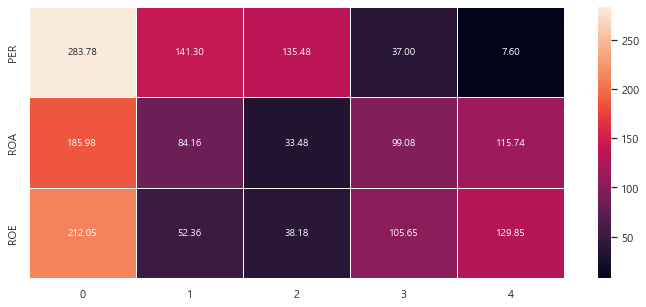

In [14]:
# 투자 지표와 수익률 간 약한 상관관계가 있던 소프트웨어 기업

s_data = data.loc[data['Sector'] == "소프트웨어 개발 및 공급업"] # 필터링
result = []

for col in ["PER", "ROA", "ROE"]:
    inve_list = np.array([10**8] * 5)
    for year in range(2014, 2020):
        y_data = s_data.loc[data['연도'] == year]
        group_list = pd.qcut(y_data[col], 5, labels = range(5)).astype(int)
        for group in range(5):
            ror_list = y_data.loc[group_list == group, '수익률']
            inve_per_stock = inve_list[group] / len(ror_list)

            profit = (inve_per_stock * ror_list / 100).sum()
            inve_list[group] += profit

    profit_ratio_list = (inve_list - 10 ** 8) / 10 ** 8 * 100
    result.append(profit_ratio_list)

result = pd.DataFrame(result, columns = range(5), index = ["PER", "ROA", "ROE"])

plt.figure(figsize = (12, 5))
sns.heatmap(result, annot = True, linewidth = 1, fmt = ".2f")

# PER과 수익률 간 관계가 보다 명확히 드러났지만 ROE, ROA는 양 극단의 수익률이 가장 높으므로 명확한 관계를 찾지 못함